In [45]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from data_loading import load_games, load_data, board_to_tensor
from moves_encoder import MovesEncoder
from typing import List
from chess.pgn import Game
from chess import Board, Move
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from Model import Model

from tqdm import tqdm
from EarlyStopping import EarlyStopping
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data processing

In [13]:
games = load_games('lichess_elite_2023-05.pgn')

encoder = MovesEncoder()
data_generator = load_data(games, encoder, limit_moves=8_000_000)

X, y = [], []
for X_data, y_data in data_generator:
    X.append(X_data)
    y.append(y_data)

X = np.array(X)
y = np.array(y)

In [14]:
# train test split
from sklearn.model_selection import train_test_split

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.125, random_state=42)  # 0.125 * 0.8 = 0.1

In [17]:
# prepare for pytorch
X_train = torch.tensor(X_train, dtype=torch.bool)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.bool)
y_test = torch.tensor(y_test, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.bool)
y_val = torch.tensor(y_val, dtype=torch.float32)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
val_dataset = TensorDataset(X_val, y_val)


In [20]:
torch.save(train_dataset, 'train_dataset.pt')
torch.save(test_dataset, 'test_dataset.pt')
torch.save(val_dataset, 'val_dataset.pt')

## Loading the processed datasets

In [28]:
train_dataset: TensorDataset = torch.load('train_dataset.pt')
test_dataset: TensorDataset = torch.load('test_dataset.pt')
val_dataset: TensorDataset = torch.load('val_dataset.pt')

In [29]:
len(train_dataset), len(test_dataset), len(val_dataset)

(5600000, 1600000, 800000)

In [30]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
validation_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [31]:
encoder = MovesEncoder()

Number of moves: 4608


## Modelling

In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [33]:
model = Model(num_actions=encoder.num_actions).to(device)

In [34]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Training

In [35]:
def train_model(model: torch.nn.Module, criterion: torch.nn.CrossEntropyLoss, optimizer: torch.optim.Optimizer, train_loader: DataLoader, validation_loader: DataLoader, epochs = 150, save_every = 10):
    model.to(device)
    early_stopping = EarlyStopping(patience=5, min_delta=0.001)

    history = {
        'epoch': [],
        'train_loss': [],
        'val_loss': [],
    }

    for epoch in range(epochs):
        model.train()

        # training
        running_train_loss = 0.0
        for data in tqdm(train_loader):
            inputs, labels = data
            inputs, labels = inputs.to(device).float(), labels.to(device).long()

            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()

            # gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            running_train_loss += loss.item()
        
        epoch_train_loss = running_train_loss / len(train_loader)

        # validation
        model.eval()
        running_val_loss = 0.0

        with torch.no_grad():
            for data in validation_loader:
                inputs, labels = data
                inputs, labels = inputs.to(device).float(), labels.to(device).long()

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
            
        epoch_val_loss = running_val_loss / len(validation_loader)

        history['epoch'].append(epoch + 1)
        history['train_loss'].append(epoch_train_loss)
        history['val_loss'].append(epoch_val_loss)

        print(f'Epoch {epoch + 1}/{epochs} - Train loss: {epoch_train_loss:.4f} - Validation loss: {epoch_val_loss:.4f}')

        # saving the model
        if (epoch + 1) % save_every == 0:
            torch.save(model.state_dict(), f'model_epoch_{epoch + 1}.pth')

        # early stopping
        if early_stopping.early_stop(epoch_val_loss):
            print(f'Early stopping on epoch {epoch+1}')
            torch.save(model.state_dict(), f'model_final_epoch{epoch + 1}.pth')
            break
    
    history_df = pd.DataFrame(history)
    return history_df

In [36]:
history = train_model(model, criterion, optimizer, train_loader, validation_loader, epochs=20, save_every=2)

100%|██████████| 87500/87500 [1:02:12<00:00, 23.44it/s]


Epoch 1/20 - Train loss: 2.8333 - Validation loss: 2.2823
    Validation loss decreased (inf --> 2.2823). Resetting counter to 0. New threshold is 2.2833


100%|██████████| 87500/87500 [1:01:35<00:00, 23.68it/s]


Epoch 2/20 - Train loss: 2.1541 - Validation loss: 2.1604
    Validation loss decreased (2.2823 --> 2.1604). Resetting counter to 0. New threshold is 2.1614


100%|██████████| 87500/87500 [1:01:37<00:00, 23.67it/s]


Epoch 3/20 - Train loss: 2.0316 - Validation loss: 2.1281
    Validation loss decreased (2.1604 --> 2.1281). Resetting counter to 0. New threshold is 2.1291


100%|██████████| 87500/87500 [1:00:57<00:00, 23.92it/s]


Epoch 4/20 - Train loss: 1.9593 - Validation loss: 2.1279
    Validation loss decreased (2.1281 --> 2.1279). Resetting counter to 0. New threshold is 2.1289


100%|██████████| 87500/87500 [1:01:51<00:00, 23.57it/s]


Epoch 5/20 - Train loss: 1.9096 - Validation loss: 2.1395


100%|██████████| 87500/87500 [1:00:48<00:00, 23.98it/s]


Epoch 6/20 - Train loss: 1.8776 - Validation loss: 2.1525


100%|██████████| 87500/87500 [1:01:17<00:00, 23.79it/s]


Epoch 7/20 - Train loss: 1.8430 - Validation loss: 2.1594


100%|██████████| 87500/87500 [1:01:24<00:00, 23.75it/s]


Epoch 8/20 - Train loss: 1.8236 - Validation loss: 2.1808


100%|██████████| 87500/87500 [1:04:14<00:00, 22.70it/s]


Epoch 9/20 - Train loss: 1.7980 - Validation loss: 2.2691
Early stopping on epoch 9


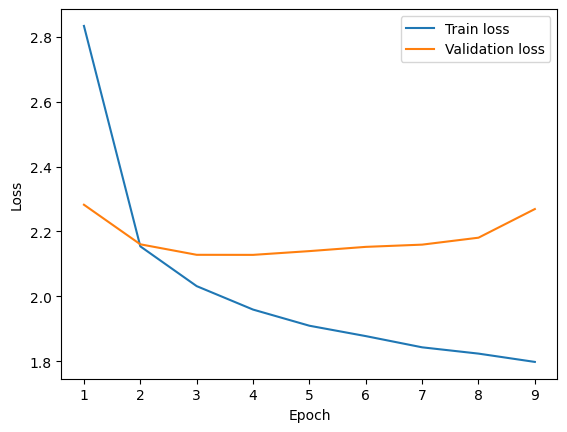

In [50]:
import matplotlib.pyplot as plt

plt.plot(history['epoch'], history['train_loss'], label='Train loss')
plt.plot(history['epoch'], history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

**NOTE**: The model above took too long to train, overfitted, and ended up performing worse than an older model with 512 neurons in `fc1`. Evaluation below uses the older model.

## Evaluation

In [ ]:
# load the model
encoder = MovesEncoder()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Model(num_actions=encoder.num_actions).to(device)
model.load_state_dict(torch.load('model_epoch_12.pth'))
model.eval()

Number of moves: 4608


Model(
  (conv1): Conv2d(19, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (fc1): Linear(in_features=8192, out_features=512, bias=True)
  (fc_relu1): ReLU()
  (fc2): Linear(in_features=512, out_features=4608, bias=True)
)

In [47]:
from sklearn.metrics import accuracy_score

# test
model.eval()
running_test_loss = 0.0
all_labels = []
all_preds = []

with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device).float(), labels.to(device).long()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_test_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

test_loss = running_test_loss / len(test_loader)
accuracy = accuracy_score(all_labels, all_preds)

test_loss, accuracy

(2.1437154840373993, 0.391163125)